# **PREDICTING HOUSE PRICES IN AMES, IOWA: ADVANCED REGRESSION TECHNIQUES**

## **Author: Boni M. Ale, MD, MSc, MPH**

### Date: 29 April 2022

# **1. Introduction**

The Ames Housing dataset is a famous and widely used dataset in the field of machine learning and statistics. It contains information on 1,460 residential properties sold in Ames, Iowa between 2006 and 2010. The dataset contains a wide range of information about each property, including its location, size, age, condition, and various features such as the number of bedrooms, bathrooms, and other amenities. 

The dataset was compiled by Dean De Cock for use in data analysis and regression modeling competitions, and is often used as a benchmark dataset in the field.

I will use this data set to predict the house prices in IOWA using selected advanced regression techniques and compare the performance of each of them. 

#### *Load Libraries*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder

from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

#### *Loading dataset*
We will load the raw data and the data that we previously processed using R sofware. 

In [2]:
ames_raw = pd.read_csv("./Ames_HousePrice.csv", index_col=0)
ames_raw.head()

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1,909176150,856,126000,30,RL,NaN,7890,Pave,NaN,Reg,...,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
2,905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal
3,911128020,1001,124900,30,C (all),60.0,6060,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,11,2007,WD,Normal
4,535377150,1039,114000,70,RL,80.0,8146,Pave,NaN,Reg,...,111,0,NaN,NaN,NaN,0,5,2009,WD,Normal
5,534177230,1665,227000,60,RL,70.0,8400,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,11,2009,WD,Normal


#### *Data description*

In [3]:
print("Raw Data Set's size: ", ames_raw.shape)

#separate variables into new data frames
numeric_data = ames_raw.select_dtypes(include=[np.number])
cat_data = ames_raw.select_dtypes(exclude=[np.number])
print ("There are {} numeric and {} categorical columns in ames raw data".format(numeric_data.shape[1],cat_data.shape[1]))


Raw Data Set's size:  (2580, 81)
There are 38 numeric and 43 categorical columns in ames raw data


The data dictionnary can be found [here](https://www.kaggle.com/competitions/stat101ahouseprice/data)

# **2. Exploratory Data Analysis**

At this stage we will explore the data by showing graph and show relationship between variables. 

## **2. 1. Numerical Variables Exploration**
Let's show all numerical variables using an histograms. This will allow us to see the distribution of each variable. 

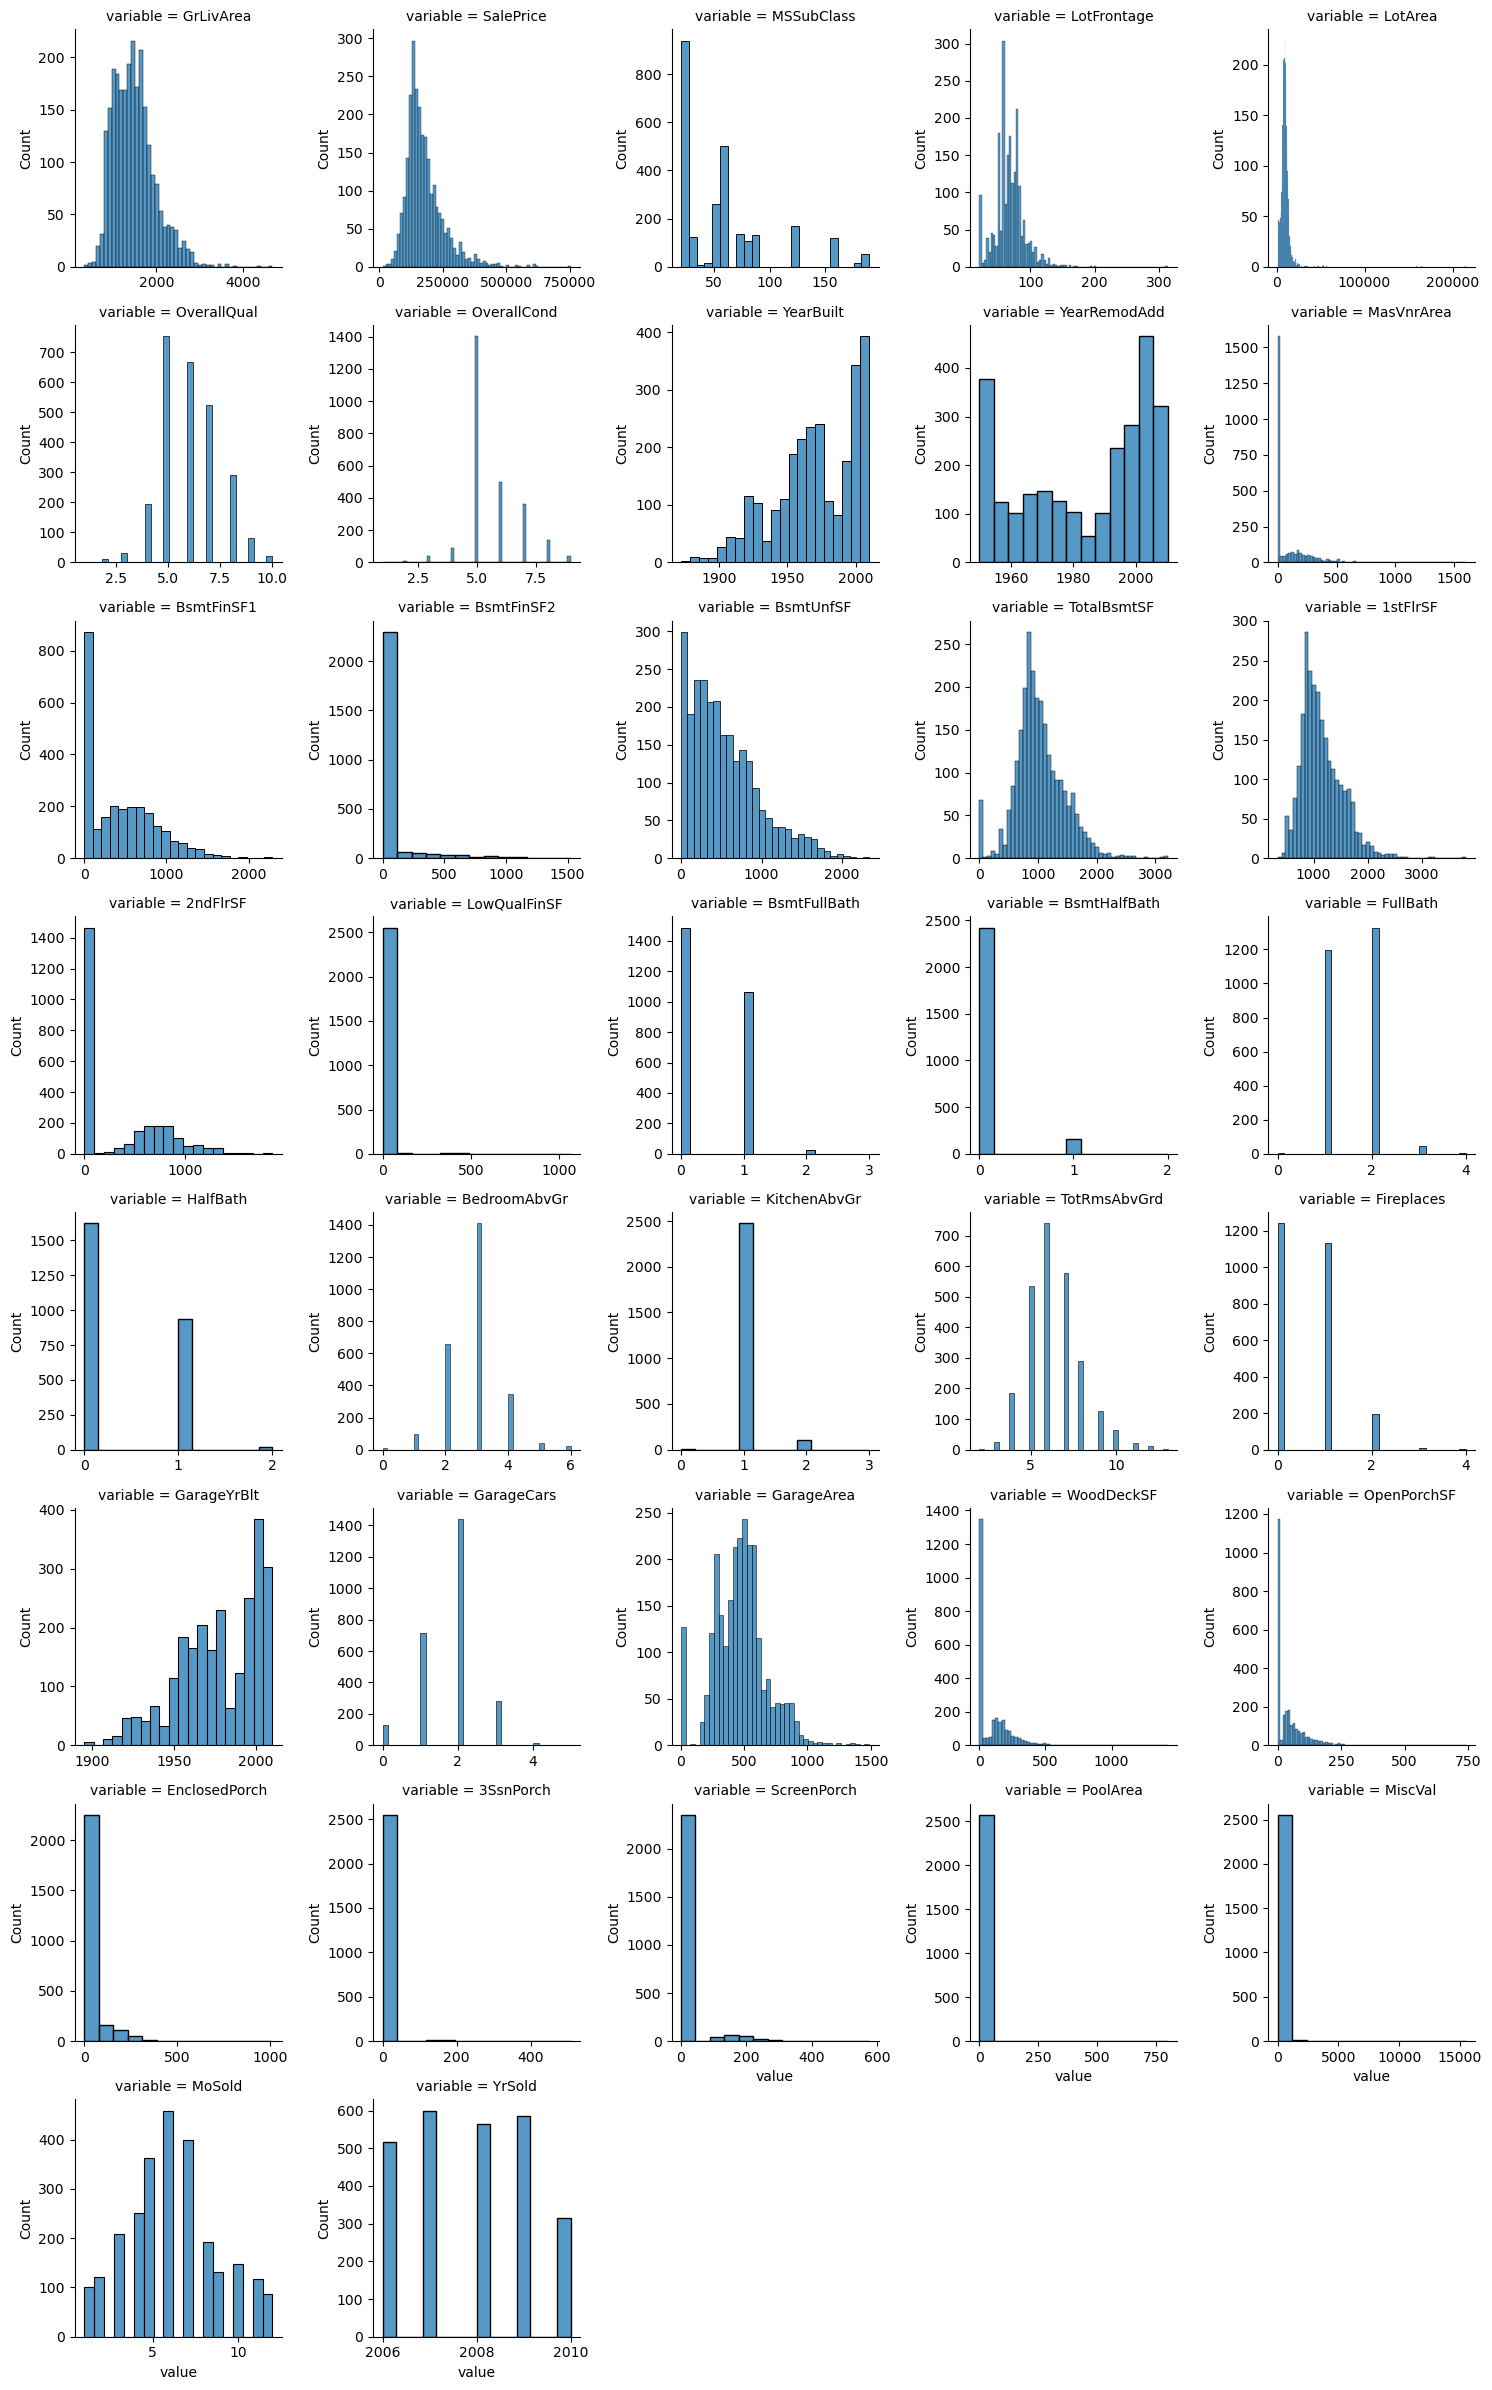

In [4]:
num = [f for f in ames_raw.columns if ames_raw.dtypes[f] != 'object']
num.remove('PID')
num

nd = pd.melt(ames_raw, value_vars = num)
nd
barplot_ames = sns.FacetGrid (nd, col='variable',
                    col_wrap=5, 
                    sharex=False, 
                              sharey = False
                   )
barplot_ames = barplot_ames.map(sns.histplot, 'value')
plt.show("barplot_ames")

We can see that several variables are not normally distributed. Our outcome variable which is sale price is right skewed. Let's confirm this with qqnorm plot and check its Skewness and Kurtosis statistics.

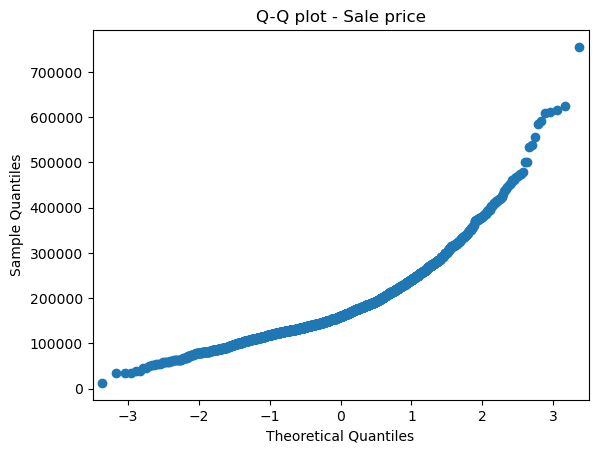

In [5]:
fig_qqplot = sm.qqplot(ames_raw.loc[:,"SalePrice"])
plt.title("Q-Q plot - Sale price")
plt.show()

In [6]:
print(f"""Skewness: {ames_raw.loc[:,"SalePrice"].skew()}
Kurtosis: {ames_raw.loc[:,"SalePrice"].kurt()}""")

Skewness: 1.7608017894946901
Kurtosis: 5.432800105464818


The skewness is less than 2 which is considered indicative of non-substantial nonnormality." (Hair et al., 2022, p. 66). However, the kurtosis is more than 2 which indicate that the distribution is too peaked as opposed to what the skewness statistics was showing. 

## **2. 2. Categorical Variables Exploration**

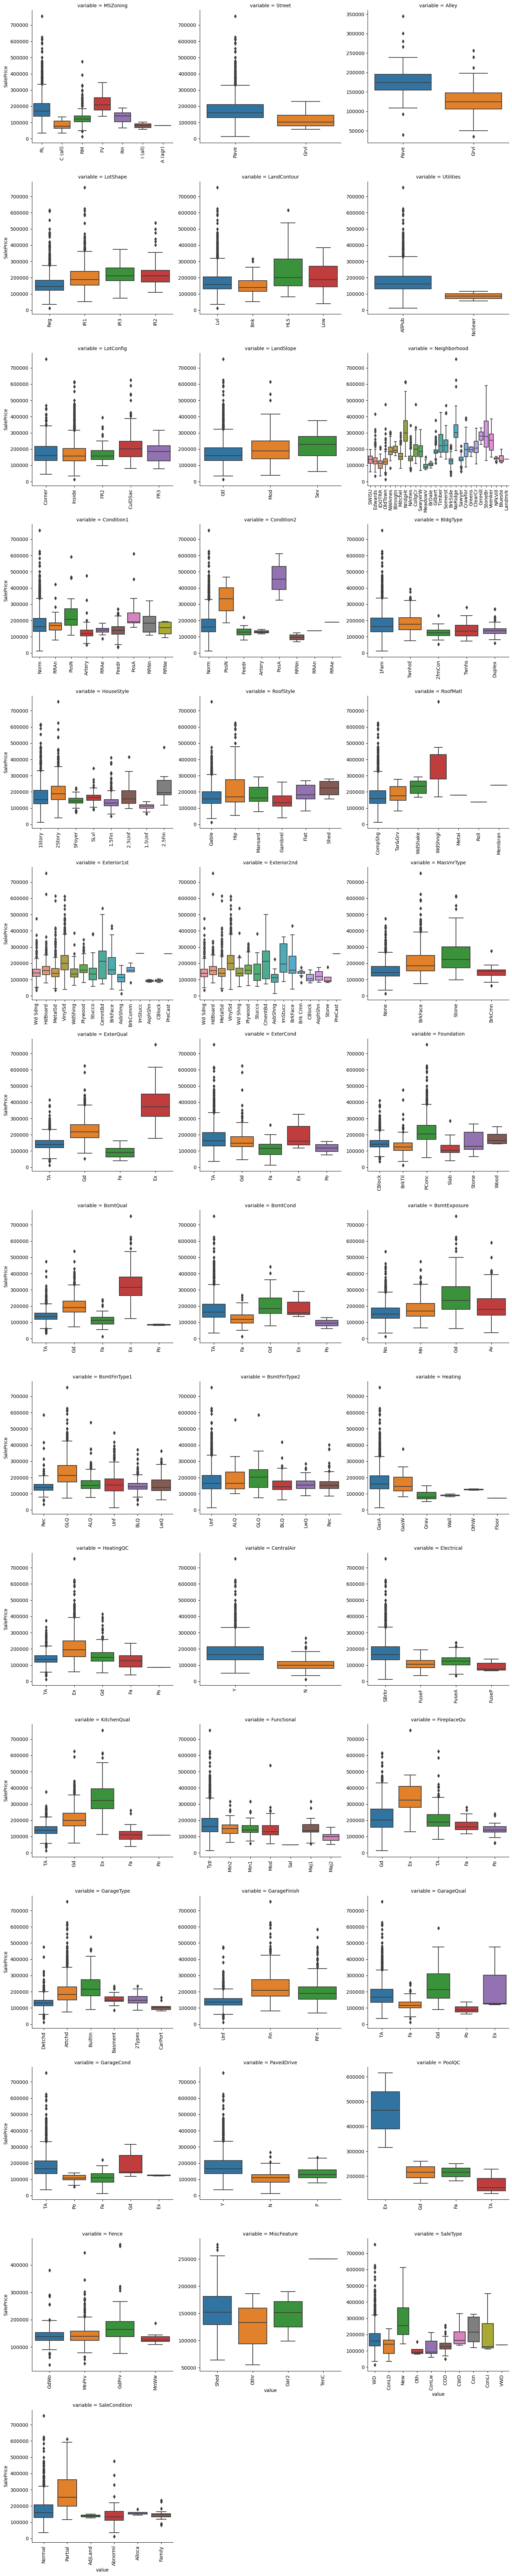

In [7]:
def boxplot(x,
            y,
            **kwargs
           ):
            sns.boxplot(x=x,y=y)
            x = plt.xticks(rotation=90)
            

ames_data_cat = [f for f in ames_raw.columns if ames_raw.dtypes[f] == 'object']

boxplot_data_ames = pd.melt(ames_raw, id_vars='SalePrice', value_vars=ames_data_cat)

boxplot_ames = sns.FacetGrid(boxplot_data_ames, 
    col='variable', 
    col_wrap=3, 
    sharex=False, 
    sharey=False,
    height=5)


boxplot_ames = boxplot_ames.map(boxplot, 'value','SalePrice')
plt.show()

Some variables like: 
- General zoning classification of the sale (ms_zoning)
- street
- alley
- utilities
- proximity to various conditions (if more than one is present) (condition2)
- building type
- roof material
- masonry veneer type
- external quality and external condition
- presence of heating and Heating quality and condition (heating_qc)
- Present condition of the material on the exterior(exter_cond)
- Height of the basement (bsmt_qual)
- General condition of the basement (bsmt_cond)
- Walkout or garden level basement walls: Refers to walkout or garden level walls (bsmt_exposure)
- kitchen quality
- neighborhoods

seems to be associated with house prices. 


## 2.3. Data Wrangling

### 2.3.1. Missing Data 

#### Missing data exploration

Let's identify any missing value. Depending on the extend, we will decide on droping the variable or imput the data based on the missingness mecanism. 

In [8]:
mis_data_count = ames_raw.isnull().sum()
mis_data_percent = ames_raw.isnull().sum() / len(ames_raw) * 100

missing_dataframe = pd.DataFrame({
    'Count': mis_data_count,
    'Percent': mis_data_percent
})



missing_dataframe = missing_dataframe[missing_dataframe.Count > 0]
missing_dataframe.sort_values(by='Count', ascending=False, inplace=True)

print(f"There are {missing_dataframe.shape[0]} features having missing data.\n")
print("Top 15 missing value features:")
missing_dataframe.head(15)

There are 27 features having missing data.

Top 15 missing value features:


,Count,Percent
PoolQC,2571,99.651163
MiscFeature,2483,96.240310
Alley,2412,93.488372
Fence,2055,79.651163
FireplaceQu,1241,48.100775
LotFrontage,462,17.906977
GarageCond,129,5.000000
GarageQual,129,5.000000
GarageFinish,129,5.000000
GarageYrBlt,129,5.000000


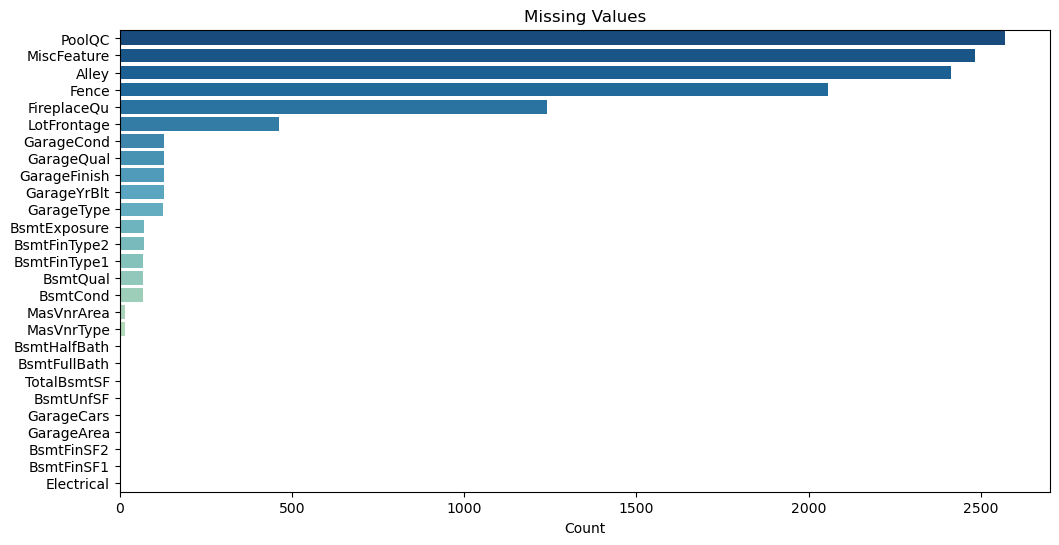

In [9]:
plt.figure(figsize=(12, 6))
sns.barplot(y=missing_dataframe.index,
            x=missing_dataframe.Count,
            palette='GnBu_r')
title = plt.title("Missing Values")
plt.show()

From the above table and graph, we can see that 15 categorical variabeles *(PoolQC, MiscFeature, Alley, Fence, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, MasVnrType)* and 10 numerical variables *(GarageArea, GarageCars, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath, MasVnrArea)* and other 3 variables *(Electrical, LotFrontage, GarageYrBlt)* were missing. 

However, for the categorical and numerical variables in this list, if we consult the data dictionary, these are variables with None recording as NA or 0 recorded as NA. This means these variables are not really missing but need to be recoded. For the other 3 variables, I will perform some imputations. 

#### Missing data recoding and imputation


###### Categorical Variables recoding

In [10]:
cat_missing = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]
ames_raw[cat_missing] = ames_raw[cat_missing].fillna("None")

###### Numerical Variables recoding


In [11]:
num_missing = [
    'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'
]

ames_raw[num_missing] = ames_raw[num_missing].fillna(0)

###### Data Imputation for specific variables

Here, I will make some decision about each variables. 

For instance, 
- I will impute Functional, MSZoning, Electrical, KitchenQual, Exterior1st, Exterior2nd, SaleType, Utilities with their modes because these variables has several levels
- I will impute LotFrontage with its mean because this is a continuous variable, and 
- I will impute GarageYrBlt with YearBuilt because the garage are probably built the same year as the houses. 

In [12]:
specific_vars = [
    'Functional', 'MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st',
    'Exterior2nd', 'SaleType', 'Utilities'
]


imputer = SimpleImputer(strategy='most_frequent')
ames_raw[specific_vars] = pd.DataFrame(imputer.fit_transform(ames_raw[specific_vars]), index=ames_raw.index)

ames_raw.LotFrontage = ames_raw.LotFrontage.fillna(ames_raw.LotFrontage.mean())
ames_raw.GarageYrBlt = ames_raw.GarageYrBlt.fillna(ames_raw.YearBuilt)

We can now check if there is still any missing data in our database

In [14]:
sum(ames_raw.isnull().sum())

0

Fantastic! We have now no missing data in our database. All missing data have been handled. 

In [ ]:
# Ordinal categorical columns
label_encoding_cols = [
    "MSSubClass", "MSZoning",
    "Street","Alley","LotShape","LandContour","Utilities",
    "LotConfig", "LandSlope","Neighborhood",
    "Condition1", "Condition2","BldgType",
    "HouseStyle", "OverallQual", "OverallCond",
    "RoofStyle", "RoofMatl", "Exterior1st",
    "Exterior2nd", "MasVnrType",  "ExterQual", "ExterCond",
    "Foundation", "BsmtQual","BsmtCond",
    "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
    "Heating", "HeatingQC", "CentralAir",
    "Electrical", "KitchenQual", "Functional",
    "FireplaceQu", "GarageType", "GarageFinish","GarageQual",
    "GarageCond", "PavedDrive", "PoolQC",
    "Fence", "MiscFeature", "SaleType", "SaleCondition"
]

# Apply Label Encoder
label_encoder = LabelEncoder()

for col in label_encoding_cols:
            ames_raw[col] = label_encoder.fit_transform(ames_raw[col])

In [ ]:
ames_data = ames_raw.drop([
                    "PID"
                   ], axis = 1)
ames_data

In [ ]:
## Check correlation between sales price and features for prediction 
ames_data.corr()['SalePrice'].sort_values(ascending=False)

In [ ]:
## Check this graphically 
plt.figure(figsize = (12,10))
barplot_corr = ames_data.corr()['SalePrice'].sort_values(ascending=True).plot(kind='barh')
plt.show("barplot_corr")

    The correlation between sale price and above grade (ground) living area square feet is high (0.71)

In [ ]:
## Create X and Y axis 
X = ames_data.drop(["SalePrice"], axis = 1)
y = ames_data["SalePrice"]

In [ ]:
## Now we will split out data set to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 5)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

**Linear Regression Modelling**

In [ ]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

In [ ]:
## Let's make some predictions
y_train_predicted_log = linreg.predict(X_train)
y_test_predicted_log = linreg.predict(X_test)
y_train_predicted = 10**y_train_predicted_log
y_test_predicted = 10**y_test_predicted_log


In [ ]:
## Prediction in the train 
y_train_predicted


In [ ]:
## Prediction in the test data
y_test_predicted

In [ ]:
## Score our “train” and “test” results.
linreg_train_r2 = linreg.score(X_train, y_train)
linreg_test_r2 = linreg.score(X_test, y_test)
print("Training R^2")
print(linreg_train_r2)
print("Test R^2")
print(linreg_test_r2)

We have tried to run the model by removing the highly correlated variable from the model but the prediction accuracy remain the same. 

In [ ]:
 ## Let's measure the forecasting accuracy of our model using Root Mean Square Error (RMSE)
linreg_train_rmse_log = np.sqrt(mean_squared_error(y_train, y_train_predicted_log))
linreg_train_rmse = 10**linreg_train_rmse_log
linreg_test_rmse_log = np.sqrt(mean_squared_error(y_test, y_test_predicted_log))
linreg_test_rmse = 10**linreg_test_rmse_log
print("Training RMSE","Test RMSE")
print(linreg_train_rmse, linreg_test_rmse)   

In [ ]:
result_data = ames_data.iloc[ames_data.index.isin(X_train.index),:].copy()
result_data['y_predicted'] = np.round(linreg.predict(X_train)) ** 10
result_data['SalePrice'] =  np.round (result_data['SalePrice'] ** 10)
result_data['y_diff'] = np.round (result_data['SalePrice'] - result_data['y_predicted'])

In [ ]:
result_data.loc[:,["SalePrice", "y_predicted", "y_diff"]].head(20)

**Ridge Regression**

In [ ]:
## define a set of alphas to test Ridge and Lasso models with
test_alphas = [0.001, 0.01, 0.1, 1, 10, 100, 300, 500, 700, 1000, 10000, 100000]
ridge = RidgeCV(alphas=test_alphas, cv=3)
lasso = LassoCV(alphas=test_alphas, cv=3)
ss = StandardScaler()
X_train_scaled = ss.fit(X_train)
X_test_scaled = ss.fit(X_test)

In [ ]:
X_train

In [ ]:
ridge.fit(X_train, y_train)

In [ ]:
ridge.alpha_

**LASSO Regression**

**Random Forest**

In [ ]:
# fit the model
model_rf = RandomForestRegressor(random_state=1)
model_rf.fit(X_train, y_train)